## Pneumonia classification with CNN on X-Ray images using PyTorch

# 1. Introduction and setups
Hello everyone! In this notebook, I'm gonna use convolutional neural network models to predict pneumonia on x-ray images using PyTorch. Let's start!

# 1.1 What is pneumonia
**Pneumonia** is an infection in one or both lungs caused by bacteria, viruses, or fungi. The infection leads to inflammation in the air sacs of the lungs, which are called alveoli. The alveoli fill with fluid or pus, making it difficult to breathe. Symptoms can range from mild to serious and may include a cough with or without mucus (a slimy substance), fever, chills, and trouble breathing. How serious your pneumonia is depends on your age, your overall health, and what caused your infection. Both viral and bacterial pneumonia are contagious. 

To diagnose pneumonia, your healthcare provider will review your medical history, perform a physical exam, and order diagnostic tests such as a chest X-ray. 

![Pneumonia illustration](https://img.freepik.com/vector-gratis/saluda-e-insalubre-pulmones-humanos_1308-29197.jpg?t=st=1651922559~exp=1651923159~hmac=cc743ddf052394279d4437886c5661103454ddeca79a28b5261b3f1fe7c17603&w=996)

# 1.2 Import libraries

In [1]:
import pandas as pd
import numpy as np
import os, random, itertools

from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torchvision.transforms as T
import torchvision

# 1.3 Reproducibility
**Reproducibility** in machine learning means that you can repeatedly run your algorithm on certain datasets and obtain the same (or similar) results on a particular project. It's important to have reproducibility when you testing different models and hyperparameters or taking part in Kaggle competitions.

To obtain reproducibility, I used the next function (which was taken from [this repository](https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964) with some changes).

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
seed_everything(42)

# 1.4 Choosing device
The next line enables us to automatically choose GPU as accelerator if it is able. Otherwise, it will choose CPU.

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
device

device(type='cpu')

# 2. Loading data
**From the considered dataset description:**

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [6]:
path = '../../data/chest_xray/chest_xray'

The next function creates a dataframe that contains links to images from both classes and target values.

In [7]:
def df_from_dir(path, directory):
    path_to_nrm = os.path.join(path, directory, 'NORMAL')
    path_to_pn = os.path.join(path, directory, 'PNEUMONIA')
    
    list_class_nrm = [0] * len(os.listdir(path_to_nrm))
    list_class_pn = [1] * len(os.listdir(path_to_pn))
    
    list_path_nrm = [os.path.join(path_to_nrm, filename) for filename in os.listdir(path_to_nrm)]
    list_path_pn = [os.path.join(path_to_pn, filename) for filename in os.listdir(path_to_pn)]
    
    return pd.DataFrame({'path': list_path_nrm + list_path_pn, 'class': list_class_nrm + list_class_pn})

In [8]:
train_df = df_from_dir(path, 'train')
valid_add_df = df_from_dir(path, 'val')
test_df = df_from_dir(path, 'test')

In [9]:
train_df.head()

,path,class
0,../../data/chest_xray/chest_xray/train/NORMAL/...,0
1,../../data/chest_xray/chest_xray/train/NORMAL/...,0
2,../../data/chest_xray/chest_xray/train/NORMAL/...,0
3,../../data/chest_xray/chest_xray/train/NORMAL/...,0
4,../../data/chest_xray/chest_xray/train/NORMAL/...,0


# 3. Data analysis
Let's start from visualizing number of objects of each class in the training dataset.

In [10]:
def balance_class_plot(df):
    sns.set_theme(style='darkgrid')
    plt.figure(figsize=(6, 6))
    ax = sns.countplot(data=df, x='class')
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
    plt.show()

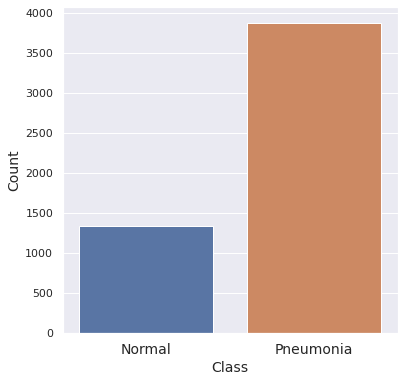

In [11]:
balance_class_plot(train_df)

As we can see, our **training dataset is imbalanced** with major class "Pneumonia" and minor class "Normal". It's a quite typical situation for medical datasets.

Now let's see what we have in the validation dataset.

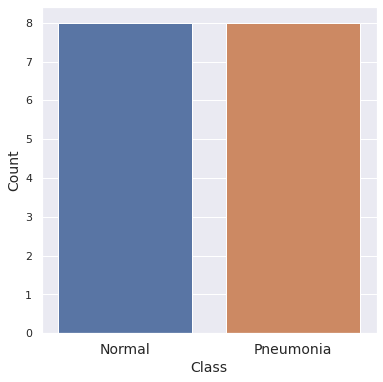

In [12]:
balance_class_plot(valid_add_df)

So, our validation dataset is balanced, but **only has 16 objects**. Therefore, we can't rely on it.

And finally, let's visualize what we have in the test dataset.

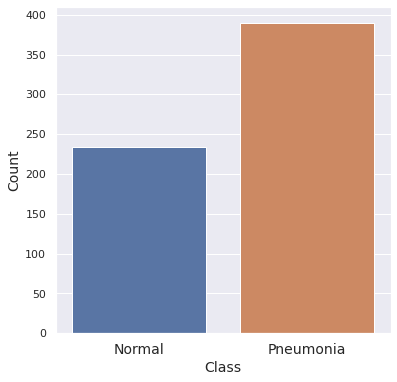

In [13]:
balance_class_plot(test_df)

As we can see, the test dataset is absolutely balanced, and we can safely use accuracy as a metric.

Also, we should look closely at our images, specifically on dimensions.

In [14]:
first_random_image = Image.open(train_df.loc[0, 'path'])
first_random_image = np.array(first_random_image)

second_random_image = Image.open(train_df.loc[1345, 'path'])
second_random_image = np.array(second_random_image)

print(f'Shape of first random image: {first_random_image.shape}\nShape of second random image: {second_random_image.shape}')

Shape of first random image: (1920, 2018)
Shape of second random image: (886, 1110)


There are two conclusions from this output:

**First**, images in this dataset have different resolutions;

**Second**, some of images even have different amount of channels.

# 4. Data preprocessing
Before training the model and making predictions, we need to prepare our data based on conclusions from the analysis.

# 4.1 Improving validation dataset
To correct the validation dataset we sacrifice and give 10% of the training dataset to validation.

In [15]:
train_ds, valid_ds = train_test_split(train_df, test_size=0.1)
valid_ds = valid_ds.append(valid_add_df)

In [16]:
train_ds = train_ds.reset_index(drop=True)
valid_ds = valid_ds.reset_index(drop=True)

# 4.2 Image augmentation

**Image augmentation** is a process of creating new training examples from the existing ones. To make a new sample, you slightly change the original image. For instance, you could make a new image a little brighter; you could cut a piece from the original image; you could make a new image by mirroring the original one, etc. By applying those transformations to the original training dataset, you could create an almost infinite amount of new training samples.

There is two main reasons for applying image augmentation:

**First**, increase the size of the dataset;

**Second**, prevent overfitting.  
 
The next transformation will be applied to each image in the validation and test dataset.

In [17]:
resize_transformation = T.Compose([T.Resize((224, 224)),
                                   T.Grayscale(num_output_channels=3),
                                   T.ToTensor()
])

This transformation only resize image to 224x224, which is widespread resolution for input in pretrained models, ensure to have 3 chanels in each image and convert it to pytorch tensor.

The next transformation will be applied to the test dataset.

In [18]:
PT_transformation = T.Compose([T.Resize((224, 224)),
                               T.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1)),
                               T.RandomHorizontalFlip(p=0.5),
                               T.Grayscale(num_output_channels=3),
                               T.ToTensor()
])

This transformation will do next:
- Resize an image to 224x224;
- Randomly rotate an image in the range (-10; 10) degrees;
- Randomly shift, both vertical and horizontal, by up to 10% of its resolution;
- Flip the image horizontal with a 50% chance;
- Ensure to have 3 channels in an image;
- Convert image to pytorch tensor.

You may ask, why did I choose specifically these transformations with these values? Because there were tested different combinations of transformations and values behind the scenes, and namely this configuration gives the best result with the choosed model (about which we will talk later :) ). 

**Note:** applying transformations before converting images to a three-channel format will noticeably decrease training time. For instance, performing the same notebook (one of the versions) but with mentioned changes speed it up from 1 hour 10 minutes to 57 minutes.

**Note 2:** ToTensor() convert a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0], i.e. it also perform image normalization.

# 4.3 Applying oversampling technique
As we know, our training dataset is imbalanced. If we ignore this, we will lose "real accuracy". Why "real accuracy" instead of common accuracy? If the dataset is highly imbalanced, the model will get a pretty high accuracy just by predicting the majority class, but fail to capture the minority class. For example, the major class contains 99% of the objects and the minor only 1%. If the model always predict major class, the accuracy will be 99%. 

There are some techniques for handling class imbalance.

First is **undersampling**. In this technique, we randomly remove samples from the majority class until all the classes have the same number of samples. This technique has a significant disadvantage in that it discards data which might lead to a reduction in the number of representative samples in the dataset.

Next is **oversampling**. In this technique, we try to make the distribution of all the classes equal in a mini-batch by sampling an equal number of samples from all the classes thereby sampling more examples from minority classes as compared to majority classes. Practically it is done by increasing the sampling probability of examples belonging to minority class thereby down-weighing the sampling probability of examples belonging to the majority class. 

In **cost-sensitive learning**, the basic idea is to assign different costs to classes according to their distribution. There are various ways of implementing cost-sensitive learning like using higher learning rate for examples belonging to majority class as compared to examples belonging to minority class or using class weighted loss functions which calculate loss by taking the class distribution into account and hence penalize the classifier more for misclassifying examples from minority class as compared to majority class.

(most information about this techniques was taken from [this article](https://towardsdatascience.com/class-imbalance-d90f985c681e))

Oversampling and cost-sensitive learning showed the almost identical result, although the second was a little harder to implement and work with. So, I used oversampling technique in this notebook.

In [19]:
def weight_sampler_over(targets, length):
    classes, counts = np.unique(targets, return_counts=True)
    weight = (1/counts)[targets]
    sampler = WeightedRandomSampler(weight, length)
    return sampler

In [20]:
train_sampler = weight_sampler_over(np.array(train_ds.loc[:,'class']), np.array(train_ds.loc[:,'class']).shape[0])
valid_sampler = weight_sampler_over(np.array(valid_ds.loc[:,'class']), np.array(valid_ds.loc[:,'class']).shape[0])

# 4.4 Creating custom dataset
Now we are going to create a class for a custom dataset. It will store the dataframe and transformation for it. Also, it will give a transformed image with a label on request.

In [21]:
class MyDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, index):
        label = self.dataframe.loc[index, 'class']
        image = Image.open(self.dataframe.loc[index, 'path'])
        image = self.transform(image)
        return image, label

In [22]:
train_dataset = MyDataset(train_ds, PT_transformation)
valid_dataset = MyDataset(valid_ds, resize_transformation)
test_dataset = MyDataset(test_df, resize_transformation)

In [23]:
len(train_dataset)

4694

Then, create dataloaders for each dataset to give batches of images instead of single images to the model.

In [24]:


bs = 32
train_dl = DataLoader(train_dataset, batch_size=bs, pin_memory=True, sampler=train_sampler)
valid_dl = DataLoader(valid_dataset, batch_size=bs*2, pin_memory=True, sampler=valid_sampler)
test_dl = DataLoader(test_dataset, batch_size=bs*2, pin_memory=True)



In [58]:
#Utility functions to un-normalize and display an image
def imshow(img):
    #img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

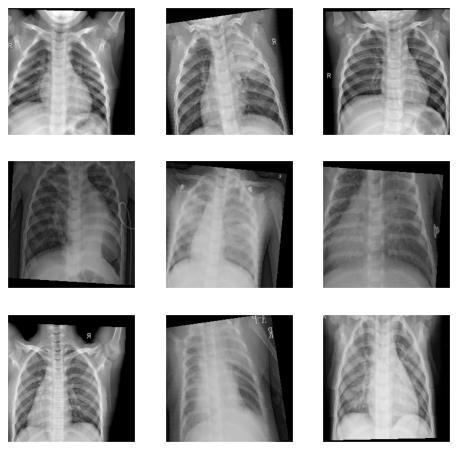

In [59]:
#Obtain one batch of training images
dataiter = iter(train_dl)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(classes[labels[idx]])

In [60]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x


In [61]:
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [62]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [63]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cpu


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [65]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

In [68]:
#Epochs
n_epochs = 4

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_dl:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_dl)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 16.643382
Epoch: 2 	Training Loss: 16.658595
Epoch: 3 	Training Loss: 16.650768
Epoch: 4 	Training Loss: 16.662046


In [69]:
#Batch of test images
dataiter = iter(test_dl)
images, labels = dataiter.next()

#Sample outputs
output = model(images)
images = images.numpy()

In [ ]:
output = output.view(batch_size, 3, 32, 32)
output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

In [ ]:
#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

In [35]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(224, 224, 3))

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

2022-05-26 20:32:43.149450: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-26 20:32:43.149479: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iotg): /proc/driver/nvidia/version does not exist
2022-05-26 20:32:43.149695: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464 

In [44]:
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
#from tensorflow.keras.optimizers import RMSprop
autoencoder.compile(optimizer=RMSprop(), 
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [45]:
batch_size =32
epochs = 2

In [ ]:
train_x = np.asarray(train_dataset).astype('float32')
#train_y = np.asarray(train_y)
validation_x = np.asarray(valid_dataset).astype('float32')
#validation_y = np.asarray(validation_y)

In [50]:
history = autoencoder.fit(train_x, train_x,
                         batch_size = batch_size,
                         epochs = epochs,
                         verbose = 1,
                         shuffle = True,
                         validation_data = (validation_x, validation_x))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type DataLoader).

# 5. Model selection
After dozens of hours of testing different versions of ResNet, VGG, DenseNet, EfficientNet, and custom nn models with different configurations, the best results showed VGG-16 with batch normalization with centered RMSprop optimizer and BCELoss. Also, a little bit worse, but close result showed VGG-13.

In [62]:
pt_model = torchvision.models.vgg16_bn(pretrained=True)

Freeze all pretrained model parameters, so this part will not be trained, and add a linear classifier with 1 output (1 and 2 outputs showed almost equivalent results).

In [26]:
for param in pt_model.parameters():
    param.requires_grad = False

pt_model.classifier[-1] = nn.Linear(in_features=pt_model.classifier[-1].in_features, out_features=1, bias=True)

pretrained_model = nn.Sequential(pt_model, nn.Sigmoid())
pretrained_model.to(device)

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [27]:
opt = optim.RMSprop(pretrained_model.parameters(), centered=True)
loss = nn.BCELoss()

The next scheduler will reduce the learning rate by half if there is no improvement in the loss metric after 3 epochs.

In [28]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=3)

# 6. Model training
The next function will train our model. It saves the best model state based on validation loss value. Also, it stores and shows metric and loss values after each epoch.

In [29]:
def fit(epochs, train_dl, valid_dl, model, opt, loss_func, metric, scheduler=None, tracker=None):
    
    val_loss_min = np.Inf
    
    for epoch in range(epochs):
        
        train_loss = 0.0
        train_metric = 0.0
        val_loss = 0.0
        val_metric = 0.0
        
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            
            pred = model(xb)
            loss = loss_func(pred, yb.unsqueeze(1).float())
            loss.backward()
            
            opt.step()
            opt.zero_grad()
            
            train_loss += loss.item()
            train_metric += metric(np.round(pred.detach().cpu().numpy()), yb.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_dl)
        avg_train_metric = train_metric / len(train_dl)
        
        model.eval()
        with torch.no_grad():
            for xb, yb in valid_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                
                pred = model(xb)
                loss = loss_func(pred, yb.unsqueeze(1).float())
                
                val_loss += loss.item()
                val_metric += metric(np.round(pred.detach().cpu().numpy()), yb.cpu().numpy())
                
            avg_val_loss = val_loss / len(valid_dl) 
            avg_val_metric = val_metric / len(valid_dl) 
            
        if tracker:
            tracker['train_loss'].append(avg_train_loss)
            tracker['train_metric'].append(avg_train_metric)
            tracker['validation_loss'].append(avg_val_loss)
            tracker['validation_metric'].append(avg_val_metric)
        
        if scheduler:
            scheduler.step(avg_val_loss)
            
        if avg_val_loss < val_loss_min:
            print(f'Epoch: {epoch + 1} - Train loss: {avg_train_loss:.3} - Train metric: {avg_train_metric:.3}\
                - Val loss: {avg_val_loss:.3} - Val metric: {avg_val_metric:.3}. Best result!')
            val_loss_min = avg_val_loss
            torch.save(model.state_dict(), 'Pneumonia_model_weights.pt')
        else:
            print(f'Epoch: {epoch + 1} - Train loss: {avg_train_loss:.3} - Train metric: {avg_train_metric:.3}\
                - Val loss: {avg_val_loss:.3} - Val metric: {avg_val_metric:.3}.')

**Note:** F1-score as a metric will not reflect reality if it is calculated separately on batches.

Then, declare and initialize necessary variables.

In [70]:
epochs = 40
tracker = {'train_loss': [], 'train_metric': [], 'validation_loss': [], 'validation_metric': []}

Finally, train our model during 50 epochs with mentioned above parameters.

In [ ]:
fit(epochs, train_dl, valid_dl, pretrained_model, opt, loss, metrics.accuracy_score, scheduler, tracker)

In [ ]:
#!ls "../../data/chest_xray/chest_xray/train/NORMAL"

As we can see, the best model was on 47 epoch. Next, let's visualize losses and metrics over epochs during the training process.

In [ ]:
x = np.arange(1, epochs + 1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(x, tracker['train_loss'], label='Train loss')
plt.plot(x, tracker['validation_loss'], label='Validation loss')
plt.title('Loss over epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss value', fontsize=14)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, tracker['train_metric'], label='Train metric')
plt.plot(x, tracker['validation_metric'], label='Validation metric')
plt.title('Metric over epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Metric value', fontsize=14)
plt.legend()

plt.show()

Ok, let's look closer starting from third epoch.

In [ ]:
x = np.arange(3, epochs + 1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(x, tracker['train_loss'][2:], label='Train loss')
plt.plot(x, tracker['validation_loss'][2:], label='Validation loss')
plt.title('Loss over epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss value', fontsize=14)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, tracker['train_metric'][2:], label='Train metric')
plt.plot(x, tracker['validation_metric'][2:], label='Validation metric')
plt.title('Metric over epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Metric value', fontsize=14)
plt.legend()

plt.show()

As we can see, the best result is on around the 47th epoch. And at the end, load our final model.

In [ ]:
pretrained_model.load_state_dict(torch.load('./Pneumonia_model_weights.pt'))

# 7. Predicting on test data
Now, let's test our model by predicting on the test dataset.

In [ ]:
predicted = []
true = []

for xb, yb in test_dl:
    xb = xb.to(device)
    predicted.append(pretrained_model(xb).detach().cpu().numpy())
    true.append(yb.numpy())
    
predicted = list(itertools.chain(*list(itertools.chain(*predicted))))
true = list(itertools.chain(*true))

f1_score = metrics.f1_score(true, np.round(predicted))
acc_score = metrics.accuracy_score(true, np.round(predicted))

print(f'F1-score: {f1_score:.3}\nAccuracy: {acc_score:.3}')

As we can see, the accuracy of the model is 90.9%, and F1-score is 92.9, which is a pretty good result. Also, let's build a confusion matrix.

In [ ]:
conf_matrix = metrics.confusion_matrix(true, np.round(predicted))
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
plt.show()

We can see that around 3/4 of all misclassified objects are false positives, which is quite good in our case. This means that if the model predicts wrong - most of the misclassified patients will have additional medical tests rather than be released and have more serious health issues later.

## Thank you for your attention!
Hope, it was interesting or useful for you. Please, upvote if you like it.